In [1]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd
import pymeshlab as pml


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def o3d_to_pml(mesh):
    o3d.io.write_triangle_mesh("temp.obj", mesh)
    mesh_pml = pml.MeshSet()
    mesh_pml.load_new_mesh("temp.obj")
    os.remove("temp.obj")
    return mesh_pml

In [3]:
def pml_to_o3d(mesh):
    mesh.save_current_mesh("temp.obj")
    mesh_o3d = o3d.io.read_triangle_mesh("temp.obj")
    os.remove("temp.obj")
    return mesh_o3d

Start building a simple tool that checks all shapes in the database. The tool should output, for each shape

-   the class of the shape
-   the number of faces and vertices of the shape
-   the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
-   the axis-aligned 3D bounding box of the shapes

In [4]:
def viz_mesh(obj_file_path, vis_option = "wireframe_on_shaded"):   
        
        if isinstance(obj_file_path, str):
            mesh = o3d.io.read_triangle_mesh(obj_file_path)
        else:
             mesh = obj_file_path
        mesh.compute_vertex_normals() 
        if vis_option == "smoothshade":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720)
        elif vis_option == "wireframe_on_shaded":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720, mesh_show_wireframe=True)
        elif vis_option == "wireframe":
            # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
            wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh) 
            o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
        elif vis_option == "world_axes":
            # Display the mesh including a world axis system.

            # Create the endpoints of each line. Each line is unit-length.
            # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
            line_endpoints = [
                [0, 0, 0],
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]

            # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
            line_indices = [[0, 1], [0, 2], [0, 3]]

            # Create a line set from the endpoints and indices
            world_axes = o3d.geometry.LineSet(
                points=o3d.utility.Vector3dVector(line_endpoints),
                lines=o3d.utility.Vector2iVector(line_indices),
            )

            # Render the line set and the mesh
            o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)
        elif vis_option == "black_background":
            # Create visualizer
            vis = o3d.visualization.Visualizer()
            vis.create_window()
            vis.add_geometry(mesh)

            # Set render options (e.g. background color)
            opt = vis.get_render_option()
            opt.background_color = np.asarray([0, 0, 0])

            # Run the visualizer
            vis.run()
            vis.destroy_window()


In [5]:
def translate_to_center(mesh):
    """
    Translate the mesh so that center is at the coordinate-frame origin.
    """
    mesh.translate(-mesh.get_center())
    return mesh

In [6]:
def scale_unitcube(mesh):
    """
    Scale mesh to fit in a unit-sized cube.
    """
    center = mesh.get_center()

    #test is mesh is centered at origin
    if center[0] > 0.001 or center[1] > 0.001 or center[2] > 0.001:
        raise ValueError(
            f'Mesh must be centered at origin'
        )
    factor = 1 / max(mesh.get_max_bound() - mesh.get_min_bound())
    print("Factor: ", factor)
    mesh.scale(factor, center)
    return mesh

In [7]:
# dbpath = r"./database/"
# mesh_path = dbpath + r"Sign/m1675.obj"

# mesh_data = []

# for class_folder in os.listdir(dbpath):
#     # Construct the full path to the subfolder
#     class_folder_path = os.path.join(dbpath, class_folder)
    
#     # Check if the item in the directory is a directory (to skip files)
#     if os.path.isdir(class_folder_path):
#         # Assuming the class folder name is the class name
#         class_name = class_folder
        
#         # Iterate through .obj files in the subfolder
#         for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
#             # Read the .obj file using tripy
#             mesh = o3d.io.read_triangle_mesh(obj_file_path)
#             filename = obj_file_path.split("\\")[-1]
#             vertices = np.asarray(mesh.vertices)
#             triangles = np.asarray(mesh.triangles)
#             filepath = class_folder_path
#             mesh_data.append([class_name, filename, len(vertices), len(triangles), obj_file_path])

#             # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")
# df = pd.DataFrame(mesh_data, columns=["Class", "Filename", "Vertices", "Triangles", "Filepath"])
# print(df)
# import pickle
# df.to_pickle("dataframe.pkl")

In [8]:
df = pd.read_pickle("dataframe.pkl")


Min, Max and average Number of triangles and Vertices over the entire dataset

In [9]:
"Min. Vertices:", df["Vertices"].min(), "Max. Vertices:", df["Vertices"].max(), "Avg. Vertices", df["Vertices"].mean()

('Min. Vertices:',
 16,
 'Max. Vertices:',
 73440,
 'Avg. Vertices',
 5025.5453080950465)

In [10]:
"Min. Triangles:", df["Triangles"].min(), "Max. Triangles:", df["Triangles"].max(), "Avg. Triangles", df["Triangles"].mean()

('Min. Triangles:',
 16,
 'Max. Triangles:',
 129881,
 'Avg. Triangles',
 10691.52597664116)

### The type of faces (e.g. only triangles, only quads, mixes of triangles and quads)

In [11]:
# dbpath = r"./database/"
# mesh_path = dbpath + r"Sign/m1675.obj"

# mesh_data = []

# for class_folder in os.listdir(dbpath):
#     # Construct the full path to the subfolder
#     class_folder_path = os.path.join(dbpath, class_folder)
    
#     # Check if the item in the directory is a directory (to skip files)
#     if os.path.isdir(class_folder_path):
#         # Assuming the class folder name is the class name
#         class_name = class_folder
        
#         # Iterate through .obj files in the subfolder
#         for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
#             # Read the .obj file using tripy
#             # mesh = o3d.io.read_triangle_mesh(obj_file_path)
#             with open(obj_file_path, 'r') as file:
#             # Iterate through each line in the file
#                 for line in file:
#                     # Check if the line starts with 'f' (case-sensitive)
#                     if line.startswith('f'):
#                         if len(line.split(" "))!= 4:
#                             print(len(line.split(" ")))

#             # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")

Only shapes of 3, otherwise it would have printed out something

### Axis-aligned bouding box

In [12]:
dbpath = r"./database/"

mesh_path = dbpath + r"Sign/m1675.obj"
mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()

# Define the eight corners of the AABB
vertices = [
    min_coords,
    [max_coords[0], min_coords[1], min_coords[2]],
    [max_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], min_coords[1], max_coords[2]],
    [max_coords[0], min_coords[1], max_coords[2]],
    max_coords,
    [min_coords[0], max_coords[1], max_coords[2]]
]

# Define the edges of the AABB
lines = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7]
]

# Create a LineSet to visualize the AABB
aabb_line_set = o3d.geometry.LineSet()
aabb_line_set.points = o3d.utility.Vector3dVector(vertices)
aabb_line_set.lines = o3d.utility.Vector2iVector(lines)

# Customize the bounding box appearance
line_set_color = np.array([1.0, 0.0, 0.0])  # Red color (R, G, B)
line_set_line_width = 5.0  # Adjust line width as needed

# Set the line set's color and line width
aabb_line_set.paint_uniform_color(line_set_color)
# aabb_line_set.line_width = line_set_line_width

# Visualize the object and its AABB
o3d.visualization.draw_geometries([mesh, aabb_line_set])

### Histogram

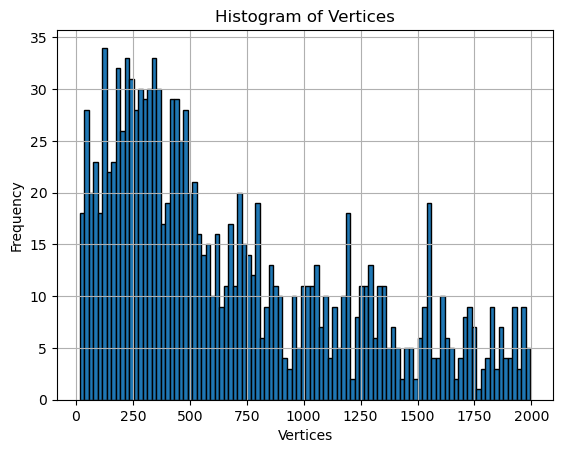

In [13]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df[df['Vertices'] < 2000]['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

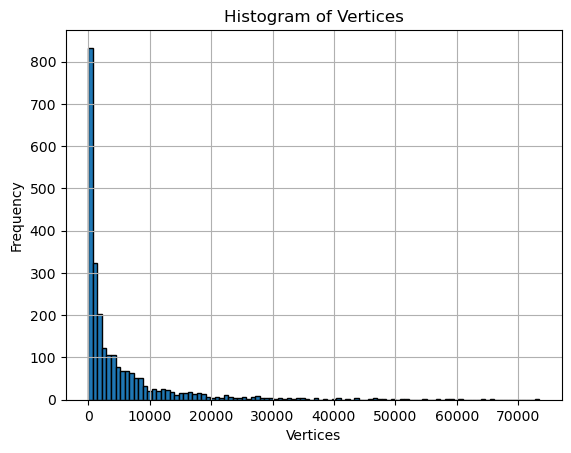

In [14]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

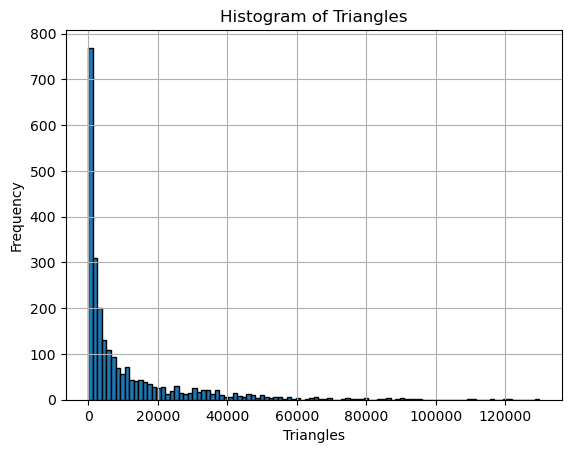

In [15]:
# Create a histogram
plt.hist(df["Triangles"], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles')
plt.grid(True)

# Display the histogram
plt.show()

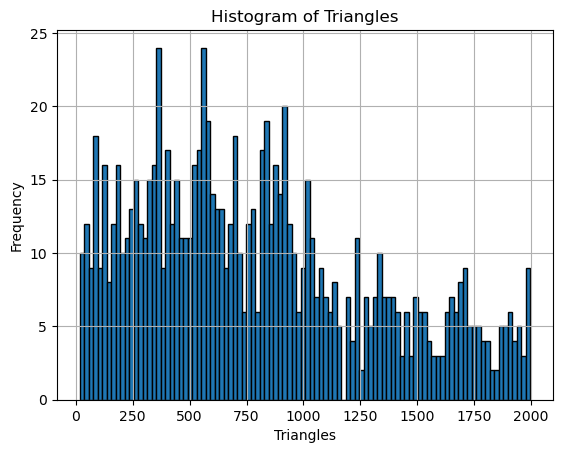

In [16]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df[df['Triangles'] < 2000]["Triangles"], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Triangles')
plt.ylabel('Frequency')
plt.title('Histogram of Triangles')
plt.grid(True)

# Display the histogram
plt.show()

### Outliers

In [17]:
highVertexDf = df[df['Vertices'] > 50000]
highVertexDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj
1705,PlantIndoors,D00080.obj,64126,34887,./database/PlantIndoors\D00080.obj
1791,PlantWildNonTree,m985.obj,50833,88945,./database/PlantWildNonTree\m985.obj
2095,Skyscraper,D00058.obj,73440,53448,./database/Skyscraper\D00058.obj
2103,Skyscraper,D00520.obj,51626,52041,./database/Skyscraper\D00520.obj


In [18]:
highTrianglesDf = df[df['Triangles'] > 100000]
highTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
406,Car,m1556.obj,35131,119540,./database/Car\m1556.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj


In [19]:
lowVertexDf = df[df['Vertices'] < 25]
lowVertexDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
716,Drum,D00709.obj,24,132,./database/Drum\D00709.obj
996,House,m434.obj,22,26,./database/House\m434.obj
1587,MultiSeat,m784.obj,24,36,./database/MultiSeat\m784.obj
2261,Tool,m1102.obj,24,52,./database/Tool\m1102.obj


In [20]:
lowTrianglesDf = df[df['Triangles'] < 25]
lowTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
1015,House,m462.obj,25,22,./database/House\m462.obj


In [21]:
highVertexDf.iloc[4,[0,1,2]]

Class           Chess
Filename    m1595.obj
Vertices        60667
Name: 457, dtype: object

In [22]:
viz_mesh(highVertexDf.iloc[4]["Filepath"])

In [23]:
viz_mesh(lowVertexDf.iloc[5]["Filepath"])

In [24]:
viz_mesh("./database/House\D00001.obj")

In [25]:
viz_mesh("./database/House\m423.obj")

In [26]:
df[df['Class']=="Bus"]

,Class,Filename,Vertices,Triangles,Filepath
305,Bus,D00084.obj,12919,75870,./database/Bus\D00084.obj
306,Bus,D00114.obj,7643,53259,./database/Bus\D00114.obj
307,Bus,D00151.obj,9415,54282,./database/Bus\D00151.obj
308,Bus,D00179.obj,5976,42567,./database/Bus\D00179.obj
309,Bus,D00182.obj,13436,86502,./database/Bus\D00182.obj
310,Bus,D00264.obj,11096,67185,./database/Bus\D00264.obj
311,Bus,D00411.obj,4964,34821,./database/Bus\D00411.obj
312,Bus,D00436.obj,4587,29118,./database/Bus\D00436.obj
313,Bus,D00446.obj,4915,28227,./database/Bus\D00446.obj
314,Bus,D00448.obj,7367,42369,./database/Bus\D00448.obj


In [27]:
# path = "./database/House\D00001.obj"
# mesh_lowpoly = pml.MeshSet()
# mesh_lowpoly.load_new_mesh(path)
# print(f"Vertices before: {mesh_lowpoly.current_mesh().vertex_number()}, Faces before: {mesh_lowpoly.current_mesh().face_number()}")

# mesh_lowpoly.meshing_isotropic_explicit_remeshing(
#         targetlen=pml.AbsoluteValue(0.02), iterations=4)


# vAfter = mesh_lowpoly.current_mesh().vertex_number()
# fAfter = mesh_lowpoly.current_mesh().face_number()
# print(f"Vertices after: {vAfter}, Faces after: {fAfter}")

### Resampling outliers

Next, if outliers contain poorly-sampled shapes (having under 100 vertices and/or faces), you need to refine these, so that feature extraction (next step) will work well. Refinement means splitting large faces into smaller ones. There are several ways to refine a mesh:

In [28]:
import pymeshlab as pml

In [29]:
# Parameters
path = lowTrianglesDf.iloc[3]["Filepath"]

def resample_mesh(path, filename, target_edge_length = 0.02, iterations = 7):
         
    mesh_lowpoly = pml.MeshSet()
    mesh_lowpoly.load_new_mesh(path)

    # Create refined (i.e. high-poly) versions of it
    print(f"Vertices before: {mesh_lowpoly.current_mesh().vertex_number()}, Faces before: {mesh_lowpoly.current_mesh().face_number()}")
    print(f"Refining mesh ({iterations} iterations)... ")
    mesh_lowpoly.meshing_isotropic_explicit_remeshing(
        targetlen=pml.AbsoluteValue(target_edge_length), iterations=iterations)
    newFilePath = f"./resampled/{filename}"
    mesh_lowpoly.save_current_mesh(newFilePath)
    print("Finished.")
    vAfter = mesh_lowpoly.current_mesh().vertex_number()
    fAfter = mesh_lowpoly.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return vAfter, fAfter, newFilePath



In [30]:
input_mesh = o3d.io.read_triangle_mesh("./database/House\D00001.obj")
input_mesh = o3d.io.read_triangle_mesh("./database/Spoon/D00474.obj")

target_triangles = 10000  # Adjust this to your desired triangle count
input_mesh.simplify_quadric_decimation(target_triangles)

# input_mesh.simplify_vertex_clustering(0.03)

TriangleMesh with 72 points and 363 triangles.

In [31]:
input_mesh

TriangleMesh with 72 points and 363 triangles.

In [32]:
newpath = "./database/House\D00001.obj"
# newpath = "./database/Spoon/D00474.obj"
# newpath = "./database/Door\D01194.obj"

mesh = o3d.io.read_triangle_mesh(newpath)
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()

In [33]:
min_coords, max_coords, np.sum(max_coords - min_coords)

(array([-0.72598302, -0.98933798, -0.54203999]),
 array([1.00829995, 0.75315899, 0.440249  ]),
 4.459068924188614)

In [34]:
targetlen = np.sum(max_coords - min_coords)/100
targetlen = 0.4
# print(targetlen)
# mesh_lowpoly = pml.MeshSet()
# mesh_lowpoly.load_new_mesh(newpath)
mesh_lowpoly = o3d_to_pml(scale_unitcube(translate_to_center(pml_to_o3d(mesh_lowpoly))))

# Create refined (i.e. high-poly) versions of it
print(f"Vertices before: {mesh_lowpoly.current_mesh().vertex_number()}, Faces before: {mesh_lowpoly.current_mesh().face_number()}")
print(f"Refining mesh ({4} iterations)... ")
mesh_lowpoly.meshing_isotropic_explicit_remeshing(
    targetlen=pml.AbsoluteValue(targetlen), iterations=2)

vAfter = mesh_lowpoly.current_mesh().vertex_number()
fAfter = mesh_lowpoly.current_mesh().face_number()
print(f"Vertices after: {vAfter}, Faces after: {fAfter}")

NameError: name 'mesh_lowpoly' is not defined

In [ ]:
mesh_lowpoly = pml.MeshSet()
mesh_lowpoly.load_new_mesh(newpath)

In [ ]:
mesh_lowpoly.meshing_decimation_quadric_edge_collapse(targetfacenum=3000)

In [ ]:
mesh_lowpoly.current_mesh().vertex_number(), mesh_lowpoly.current_mesh().face_number()

(2117, 3000)

In [ ]:
viz_mesh(pml_to_o3d(mesh_lowpoly))

In [ ]:
target_vertices=2000
factor=0.3

In [ ]:
range(int(target_vertices*(1-factor)), int(target_vertices*(1+factor)))

range(1400, 2600)

In [128]:
def remesh_increase(mesh, targetlen=0.02, iterations=3):
    print(f"Vertices before: {mesh.current_mesh().vertex_number()}, Faces before: {mesh.current_mesh().face_number()}")
    print(f"Refining mesh ({iterations} iterations)... ")
    mesh.meshing_isotropic_explicit_remeshing(
        targetlen=pml.AbsoluteValue(targetlen), iterations=iterations)

    vAfter = mesh.current_mesh().vertex_number()
    fAfter = mesh.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return mesh

In [ ]:
def resample_mesh(path, filename, target_edge_length = 0.02, iterations = 7):
         
    mesh_lowpoly = pml.MeshSet()
    mesh_lowpoly.load_new_mesh(path)

    # Create refined (i.e. high-poly) versions of it
    print(f"Vertices before: {mesh_lowpoly.current_mesh().vertex_number()}, Faces before: {mesh_lowpoly.current_mesh().face_number()}")
    print(f"Refining mesh ({iterations} iterations)... ")
    mesh_lowpoly.meshing_isotropic_explicit_remeshing(
        targetlen=pml.AbsoluteValue(target_edge_length), iterations=iterations)
    newFilePath = f"./resampled/{filename}"
    mesh_lowpoly.save_current_mesh(newFilePath)
    print("Finished.")
    vAfter = mesh_lowpoly.current_mesh().vertex_number()
    fAfter = mesh_lowpoly.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return vAfter, fAfter, newFilePath

In [137]:
def remesh(mesh_path, classname, filename, target_vertices=2000, factor=0.3):
    mesh = pml.MeshSet()
    mesh.load_new_mesh(mesh_path)
    print(f"Vertices before: {mesh_lowpoly.current_mesh().vertex_number()}, Faces before: {mesh_lowpoly.current_mesh().face_number()}")

    # if mesh.current_mesh().vertex_number() < target_vertices * (1-factor):
    count = 0
    while mesh.current_mesh().vertex_number() < target_vertices* (1-factor) and count < 5:#not in range(int(target_vertices*(1-factor)), int(target_vertices*(1+factor))):
        count += 1
        remesh_increase(mesh)

    if mesh.current_mesh().vertex_number() > target_vertices* (1+factor):
        mesh.meshing_decimation_quadric_edge_collapse(targetfacenum=int(target_vertices*1.4))

    newFilePath = f"./resampled/{classname}/{filename}"

    if not os.path.exists(f"./resampled/{classname}"):
        os.makedirs(f"./resampled/{classname}")

    mesh.save_current_mesh(newFilePath)

    vAfter = mesh_lowpoly.current_mesh().vertex_number()
    fAfter = mesh_lowpoly.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return mesh, vAfter, fAfter, newFilePath
            

In [122]:
mesh_lowpoly = pml.MeshSet()
mesh_lowpoly.load_new_mesh("./database/Shelf\m852.obj")
mesh_lowpoly = o3d_to_pml(scale_unitcube(translate_to_center(pml_to_o3d(mesh_lowpoly))))
remesh(mesh_lowpoly).current_mesh().vertex_number()

Factor:  1.0526315529425725
Vertices before: 104, Faces before: 228
Refining mesh (3 iterations)... 
Vertices after: 4053, Faces after: 8462


1789

In [141]:
df

,Class,Filename,Vertices,Triangles,Filepath
0,AircraftBuoyant,m1337.obj,1789,3800,./resampled/AircraftBuoyant/m1337.obj
1,AircraftBuoyant,m1338.obj,1789,3800,./resampled/AircraftBuoyant/m1338.obj
2,AircraftBuoyant,m1339.obj,1878,6173,./database/AircraftBuoyant\m1339.obj
3,AircraftBuoyant,m1340.obj,1789,3800,./resampled/AircraftBuoyant/m1340.obj
4,AircraftBuoyant,m1341.obj,1789,3800,./resampled/AircraftBuoyant/m1341.obj
...,...,...,...,...,...
2478,WheelChair,D00687.obj,1789,3800,./resampled/WheelChair/D00687.obj
2479,WheelChair,D00720.obj,1789,3800,./resampled/WheelChair/D00720.obj
2480,WheelChair,D00782.obj,1789,3800,./resampled/WheelChair/D00782.obj
2481,WheelChair,D00821.obj,1789,3800,./resampled/WheelChair/D00821.obj


In [146]:
viz_mesh("./resampled/AircraftBuoyant/m1337.obj")

In [ ]:
viz_mesh(pml_to_o3d(mesh_lowpoly))

In [ ]:
mesh_lowpoly.current_mesh().vertex_number()

4053

In [138]:
target_vertices = 2000
factor = 0.3
count = 0
for i, row in df.iterrows():
    if row['Vertices'] not in range(int(target_vertices*(1-factor)), int(target_vertices*(1+factor))): #or row['Vertices'] > 25000:
        _, vAfter, fAfter, newFilePath = remesh(row["Filepath"], row["Class"],row["Filename"], 2000, 0.3 )
        df.at[i, "Vertices"] = vAfter
        df.at[i, "Triangles"] = fAfter
        df.at[i, "Filepath"] = newFilePath
        count += 1
    else:
        
print(f"Edited {count} Elements")

Vertices before: 1789, Faces before: 3800
Vertices before: 778, Faces before: 1457
Refining mesh (3 iterations)... 
Vertices after: 1869, Faces after: 3640
Vertices after: 1789, Faces after: 3800
Vertices before: 1789, Faces before: 3800
Vertices before: 425, Faces before: 824
Refining mesh (3 iterations)... 
Vertices after: 1801, Faces after: 3566
Vertices after: 1789, Faces after: 3800
Vertices before: 1789, Faces before: 3800
Vertices before: 1252, Faces before: 2305
Refining mesh (3 iterations)... 
Vertices after: 4791, Faces after: 9461
Vertices after: 1789, Faces after: 3800
Vertices before: 1789, Faces before: 3800
Vertices before: 178, Faces before: 344
Refining mesh (3 iterations)... 
Vertices after: 6405, Faces after: 12798
Vertices after: 1789, Faces after: 3800
Vertices before: 1789, Faces before: 3800
Vertices before: 1093, Faces before: 1930
Refining mesh (3 iterations)... 
Vertices after: 3398, Faces after: 6551
Vertices after: 1789, Faces after: 3800
Vertices before: 17

In [ ]:
df[df['Vertices']<111]

,Class,Filename,Vertices,Triangles,Filepath
204,Bird,m47.obj,101,165,./database/Bird\m47.obj
222,Bookset,D01122.obj,108,624,./database/Bookset\D01122.obj
1662,NonWheelChair,m807.obj,104,184,./database/NonWheelChair\m807.obj
1910,RectangleTable,m913.obj,104,188,./database/RectangleTable\m913.obj
2000,Shelf,m852.obj,104,228,./database/Shelf\m852.obj
2001,Shelf,m853.obj,100,228,./database/Shelf\m853.obj
2120,Spoon,D00422.obj,109,528,./database/Spoon\D00422.obj
2121,Spoon,D00474.obj,47,78,./resampled/D00474.obj


Vertices before: 72, Faces before: 363
Refining mesh (7 iterations)... 
Finished.
Vertices after: 43, Faces after: 70

In [ ]:
average_triangles

,Class,Triangles
49,RectangleTable,1615.171875
52,Shelf,1685.511628
65,Vase,1935.550000
35,Jet,2098.300699
21,Door,2171.181818
...,...,...
20,DeskPhone,29362.850000
4,Bicycle,30098.615385
63,Truck,31413.185185
64,TruckNonContainer,33820.500000


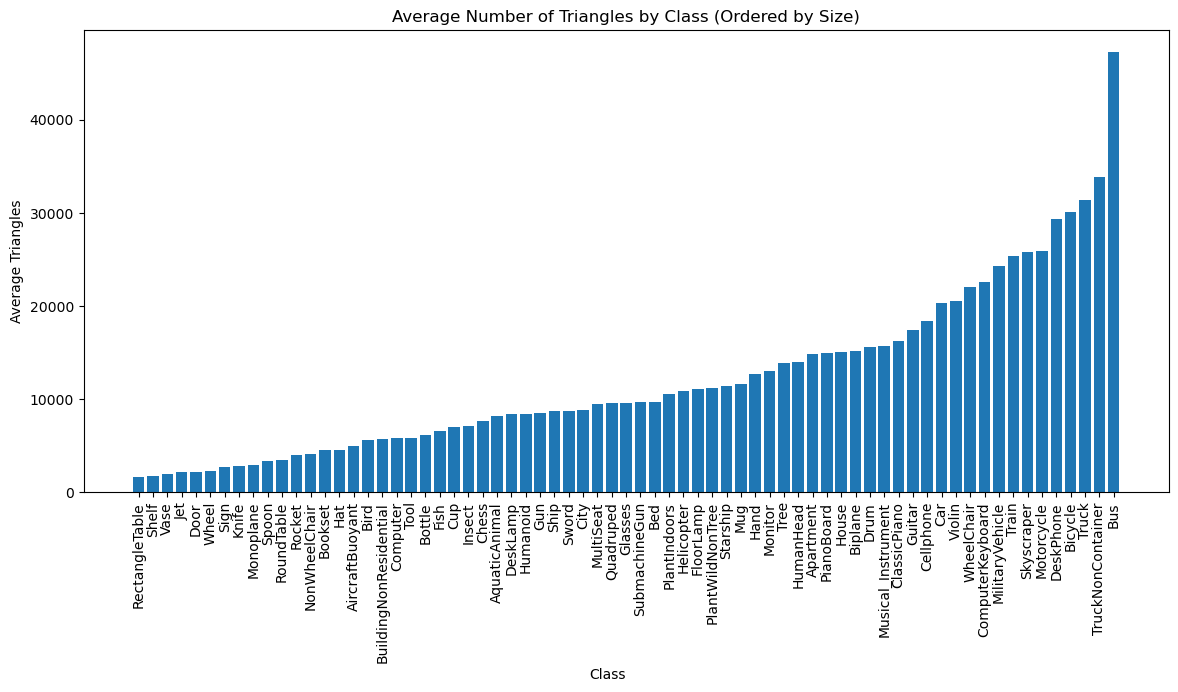

In [ ]:
average_triangles = df.groupby('Class')['Triangles'].mean().reset_index()

# Sort the DataFrame by average Triangles in descending order
average_triangles = average_triangles.sort_values(by='Triangles', ascending=True)


# Create a bar chart with angled x-axis labels
plt.figure(figsize=(14, 6))
plt.bar(average_triangles['Class'], average_triangles['Triangles'])
plt.xlabel('Class', ha='right')  # Angle the x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Average Triangles')
plt.title('Average Number of Triangles by Class (Ordered by Size)')
plt.show()

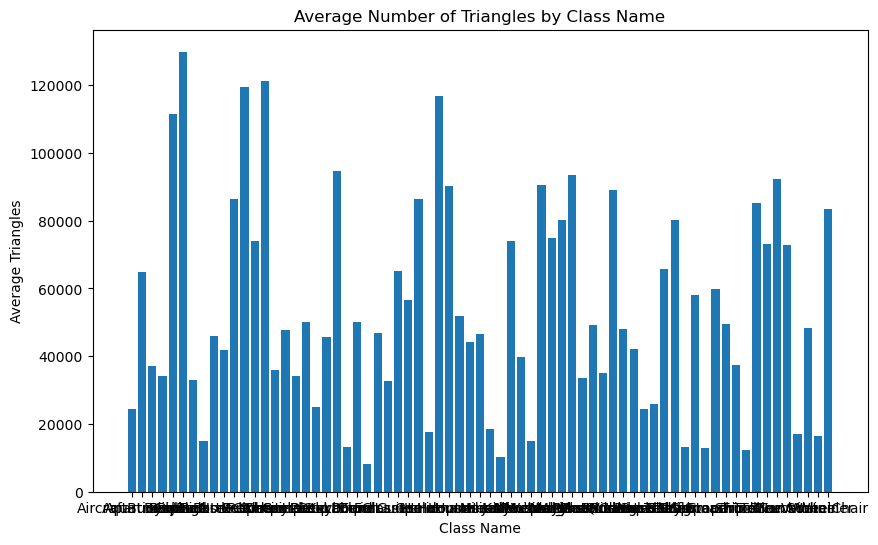

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df['Class'], df['Triangles'])
plt.xlabel('Class Name')
plt.ylabel('Average Triangles')2
plt.title('Average Number of Triangles by Class Name')
plt.show()

In [ ]:
# viz_mesh('./resampled/D00474.obj')

In [ ]:
# viz_mesh('./database/Spoon/D00474.obj')

In [ ]:
lowTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
1015,House,m462.obj,25,22,./database/House\m462.obj


In [ ]:
viz_mesh(path)

In [ ]:
viz_mesh("refined_iter4.obj")

### Statistics after resampling

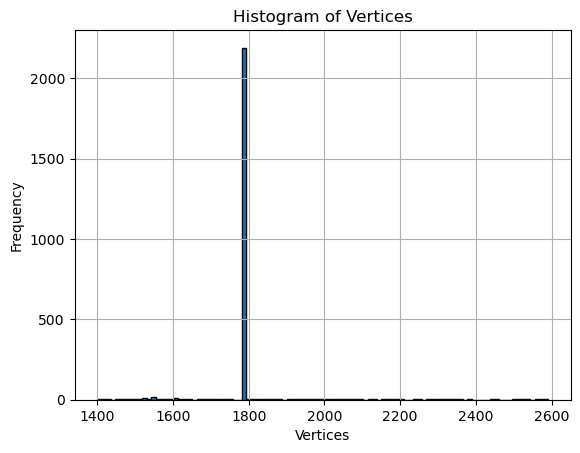

In [140]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

In [ ]:
"Min. Vertices:", df["Vertices"].min(), "Max. Vertices:", df["Vertices"].max(), "Avg. Vertices", df["Vertices"].mean()

('Min. Vertices:',
 47,
 'Max. Vertices:',
 73440,
 'Avg. Vertices',
 5255.640757148611)

In [ ]:
"Min. Triangles:", df["Triangles"].min(), "Max. Triangles:", df["Triangles"].max(), "Avg. Triangles", df["Triangles"].mean()

('Min. Triangles:',
 78,
 'Max. Triangles:',
 129881,
 'Avg. Triangles',
 11148.592025775271)

In [ ]:
viz_mesh("./resampled/D00015.obj")

In [ ]:
viz_mesh("./database/Rocket/D00015.obj")

[Open3D WARNING] Unable to load file ./database/Rocket/D00015.obj with ASSIMP


### Transformation

In [69]:
def get_eigen_vectors(mesh):
    # Load the mesh with open3d
    
    mesh.compute_vertex_normals()
    mesh.rotate(mesh.get_rotation_matrix_from_xyz((0, np.pi/4, np.pi/5)))

    # Obtain numpy array containing the mesh's vertex positions.
    # Note: modifying values in the array will also change the corresponding vertex
    # positions in the mesh object
    vertices = np.asarray(mesh.vertices)

    # Compute barycenter
    barycenter = np.mean(vertices, axis=0)

    # Align mesh and vertices to origin
    vertices -= barycenter

    # Compute covariance matrix on vertices array
    cov = np.cov(vertices.transpose())

    # Compute eigen vectors and eigen values of covariance matrix
    # The eigen vectors are the columns of the returned 2d-array
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Order the eigenvectors according to the magnitude of their corresponding eigen value
    # (from largest to smallest)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(3)]
    eigencombined.sort(key=lambda x:x[0], reverse=True)
    eigenvectors = [item[1] for item in eigencombined]
    eigenvalues = [item[0] for item in eigencombined]

    # Replace the minor eigen vector with cross product of major and medium (to enforce right-handed reference frame)
    eigenvectors.pop(2)
    eigenvectors.append(np.cross(eigenvectors[0], eigenvectors[1]))

    eigvec_startpoint = np.zeros(3)
    eigvec_points = [eigvec_startpoint] + [vec for vec in eigenvectors]
    eigvec_line_indices = [[0, 1], [0, 2], [0, 3]]
    eigvec_lineset = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(eigvec_points),
        lines=o3d.utility.Vector2iVector(eigvec_line_indices),
    )

    # Add colors to the lines
    # Red, green, blue for major, 2nd-, and 3rd-largest eigen vectors, respectively. 
    line_colors = np.array([[255,0,0], [0,255,0], [0,0,255]])
    eigvec_lineset.colors = o3d.utility.Vector3dVector(line_colors)

    return eigenvectors, eigvec_lineset

In [115]:
import copy
def transform(mesh):
    eigen_vectors,_ = get_eigen_vectors(mesh)
   
    mesh_r = copy.deepcopy(mesh)

    mesh_r.rotate(eigen_vectors, center=(0, 0, 0))

    """below this line is for visualisation"""
    # Display the mesh including a world axis system.

    # Create the endpoints of each line. Each line is unit-length.
    # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
    line_endpoints = [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    

    # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
    line_indices = [[0, 1], [0, 2], [0, 3]]

    # Create a line set from the endpoints and indices
    world_axes = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(line_endpoints),
        lines=o3d.utility.Vector2iVector(line_indices),
    )
    # world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame() 

    # Render the line set and the mesh
    o3d.visualization.draw_geometries([ mesh_r, world_axes], width=1280, height=720, mesh_show_wireframe=True)
    return mesh_r

mesh = o3d.io.read_triangle_mesh("./database/Rocket/D00015.obj")
transform(mesh)

TriangleMesh with 88 points and 156 triangles.

In [93]:
eigenvectors = get_eigen_vectors(o3d.io.read_triangle_mesh("./database/Jet\m1155.obj"))
eigenvectors

([array([ 0.77882084, -0.17065486,  0.60358514]),
  array([-0.57216044, -0.5876204 ,  0.57213171]),
  array([ 0.25704188, -0.79093564, -0.55529297])],
 LineSet with 3 lines.)

In [109]:
viz_mesh("./database/Rocket/D00015.obj")

In [54]:
o3d.visualization.draw_geometries([mesh])